In [1]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
from sklearn.metrics import accuracy_score
from torchinfo import summary
import torch.nn as nn
import argparse, os, json, sys
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import h5py
from EvalTools import *
sys.path.append("../model")
from PFINDataset import PFINDataset
from UQPFIN import UQPFIN as Model
%env HDF5_USE_FILE_LOCKING=FALSE

env: HDF5_USE_FILE_LOCKING=FALSE


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
makeFile = True

In [3]:
saved_model_loc = "../model/trained_models/"
saved_model_dict_loc = "../model/trained_model_dicts/"
all_models = [f for f in os.listdir(saved_model_loc) if "_best" in f and "_trial" not in f and "_softmax" in f and "_dropout" not in f] 
print("\n".join(all_models))
tags = []
for modelname in all_models:
    tag = modelname.strip().split('_')[-2]
    if tag not in tags:
        tags.append(tag)
print("\n".join(tags))

UQPFIN_best_jetnet_softmax_skiptop_3
UQPFIN_best_jetnet_softmax_skipwz_9
UQPFIN_best_jetnet_softmax_skiptop_2
UQPFIN_best_jetnet_softmax_skiptwz_3
UQPFIN_best_jetnet_softmax_skiptwz_2
UQPFIN_best_jetnet_softmax_skipwz_3
UQPFIN_best_jetnet_softmax_skiptop_8
UQPFIN_best_jetnet_softmax_skipwz_0
UQPFIN_best_jetnet_softmax_skiptwz_6
UQPFIN_best_jetnet_softmax_skipwz_1
UQPFIN_best_jetnet_softmax_skiptwz_5
UQPFIN_best_jetnet_softmax_skipwz_6
UQPFIN_best_jetnet_softmax_skipwz_7
UQPFIN_best_jetnet_softmax_skipwz_8
UQPFIN_best_jetnet_softmax_skiptop_7
UQPFIN_best_jetnet_softmax_skiptop_5
UQPFIN_best_jetnet_softmax_skiptop_0
UQPFIN_best_jetnet_softmax_skiptwz_7
UQPFIN_best_jetnet_softmax_skiptop_9
UQPFIN_best_jetnet_softmax_skiptwz_9
UQPFIN_best_jetnet_softmax_skiptop_4
UQPFIN_best_jetnet_softmax_skipwz_2
UQPFIN_best_jetnet_softmax_skiptop_1
UQPFIN_best_jetnet_softmax_skiptwz_1
UQPFIN_best_jetnet_softmax_skipwz_5
UQPFIN_best_jetnet_softmax_skiptwz_4
UQPFIN_best_jetnet_softmax_skiptop_6
UQPFIN_bes

In [4]:
model_results = {}

for tag in sorted(tags):
    this_files = ["../model/trained_models/" + f for f in all_models if tag in f]
    evaluator = EnsembleEvaluator(this_files)
    labels, preds, maxprobs, probs, sums, oods, uncs = evaluator.evaluate()
    acc = accuracy_score(labels[~oods], preds[~oods])*100        
    print("{} \t\t Accuracy: {:.2f}%".format(tag, acc))
    
    model_results[tag] = {'labels' : labels, 
                                      'preds': preds, 
                                      'maxprobs': maxprobs,
                                      'sums':sums, 
                                      'oods':oods,
                                      'uncs': uncs,
                                      'probs': probs}
    if makeFile:
        f = h5py.File("RESULTS_UQPFIN_Ensemble_{}.h5".format(tag), "w")
        for key in model_results[tag].keys():
            f.create_dataset(key, data = model_results[tag][key])
        f.close()
    
    del evaluator

skiptop 		 Accuracy: 82.17%
skiptwz 		 Accuracy: 84.09%
skipwz 		 Accuracy: 82.36%


skiptop


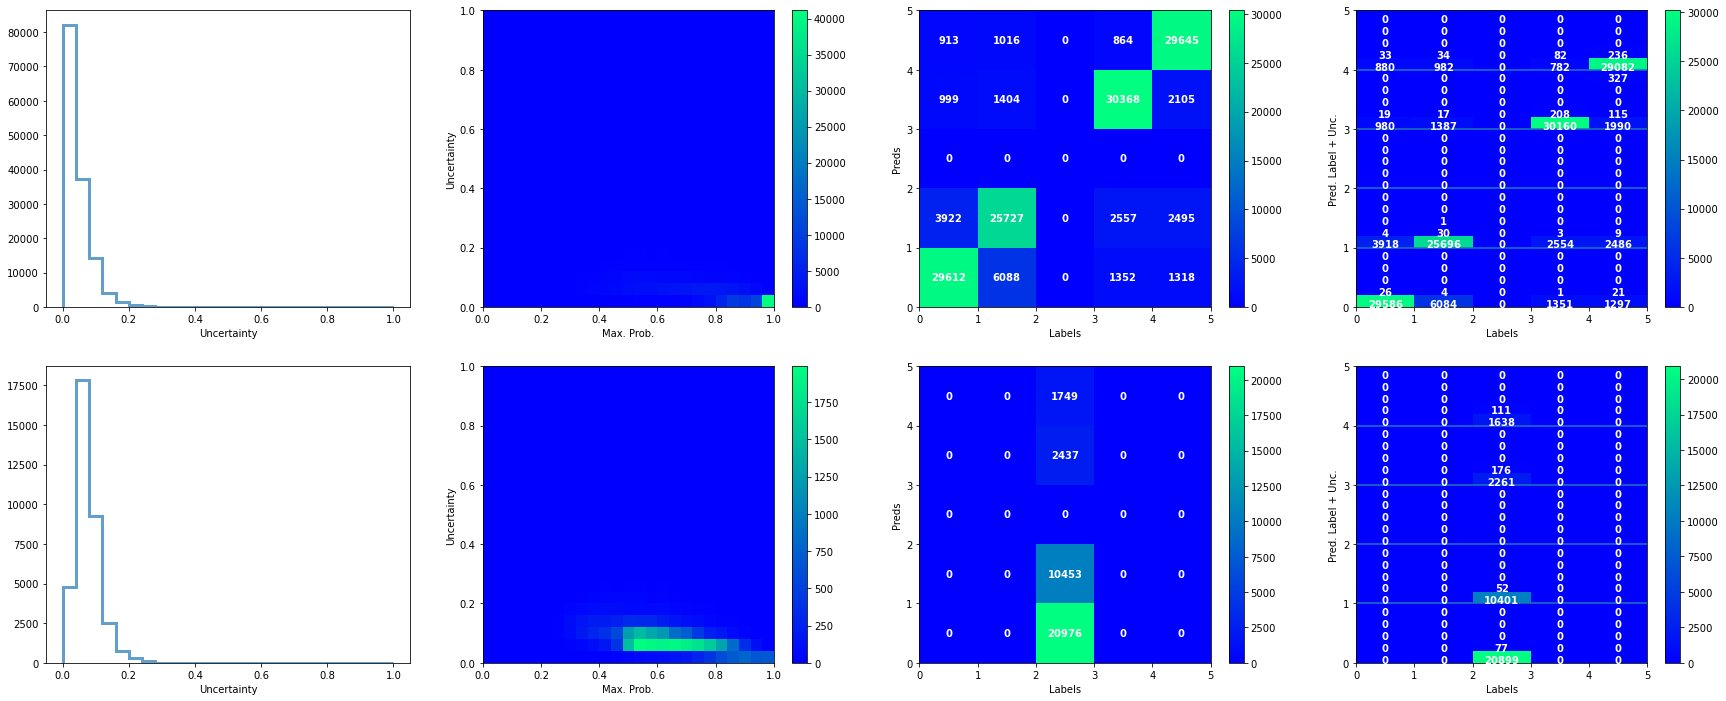

skiptwz


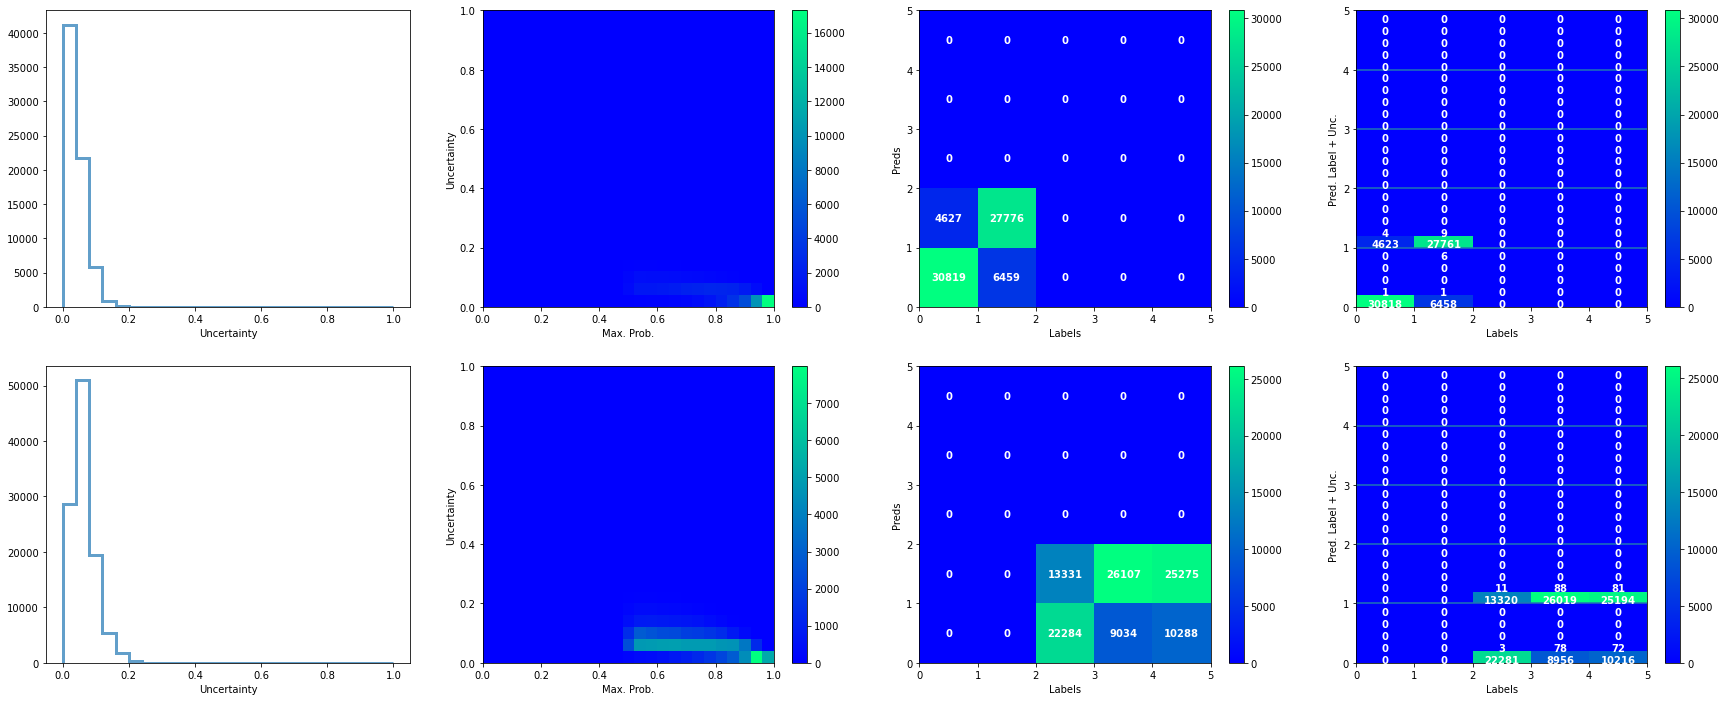

skipwz


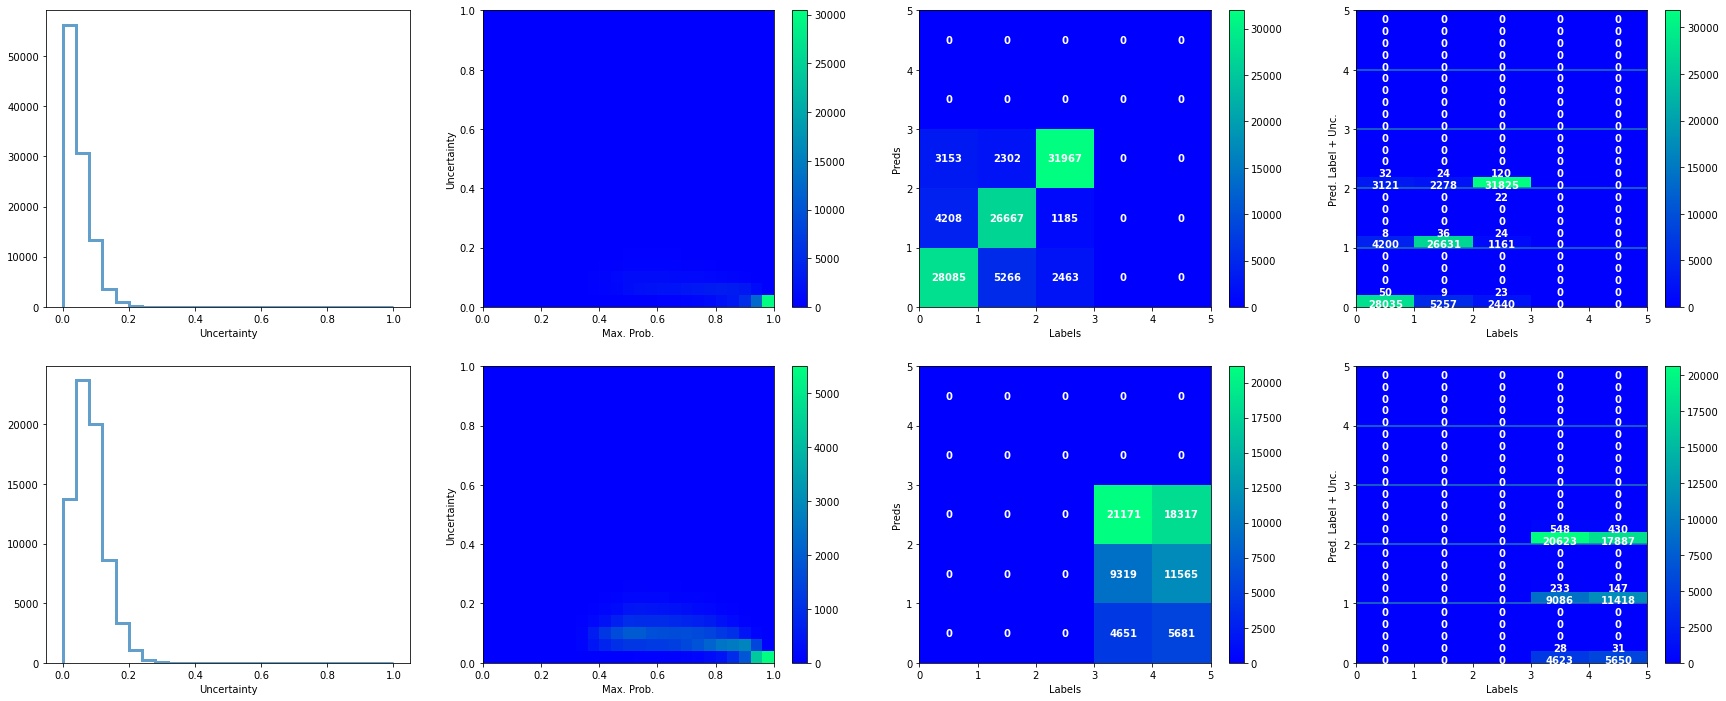

In [5]:
for key in model_results.keys():
    print(key)
    l_max = 5.1
    
    labels, preds, maxprobs, sums, oods, uncs = model_results[key]['labels'], model_results[key]['preds'], \
                                                model_results[key]['maxprobs'], model_results[key]['sums'], \
                                                model_results[key]['oods'], model_results[key]['uncs'],
    
    fig, axes = plt.subplots(2, 4, figsize=(6*5, 6*2), sharex = False, sharey = False)
    
    axes[0, 0].hist(uncs[~oods],
                    bins=np.arange(0.,1.01,0.04), 
                    label=key + '(~oods)', 
                    alpha = 0.7, 
                    histtype = 'step', linewidth = 3)
    axes[0, 0].set_xlabel("Uncertainty")
    axes[1, 0].hist(uncs[oods],
                    bins=np.arange(0.,1.01,0.04), 
                    label=key + '(oods)', 
                    alpha = 0.7, 
                    histtype = 'step', linewidth = 3)
    axes[1, 0].set_xlabel("Uncertainty")
    
    
    h = axes[0, 1].hist2d(maxprobs[~oods], uncs[~oods], 
                          cmap = 'winter',
                          bins = [np.arange(0.,1.01,0.04), np.arange(0.,1.01,0.04)])
    fig.colorbar(h[3], ax=axes[0, 1])
    axes[0, 1].set_xlabel("Max. Prob.")
    axes[0, 1].set_ylabel("Uncertainty")
    
    h = axes[1, 1].hist2d(maxprobs[oods], uncs[oods], 
                          cmap = 'winter',
                          bins = [np.arange(0.,1.01,0.04), np.arange(0.,1.01,0.04)])
    fig.colorbar(h[3], ax=axes[1, 1])
    axes[1, 1].set_xlabel("Max. Prob.")
    axes[1, 1].set_ylabel("Uncertainty")
    
    
    h = axes[0, 2].hist2d(labels[~oods], preds[~oods], 
                          cmap = 'winter',
                          bins = [np.arange(0.,l_max,1), np.arange(0.,l_max,1)])
    
    for i in range(len(h[2])-1):
        for j in range(len(h[1])-1):
            axes[0,2].text(h[1][j]+0.5,h[2][i]+0.5, int(h[0].T[i,j]), 
                           color="w", ha="center", va="center", fontweight="bold")

    fig.colorbar(h[3], ax=axes[0, 2])
    axes[0, 2].set_xlabel("Labels")
    axes[0, 2].set_ylabel("Preds")
    
    h = axes[1, 2].hist2d(labels[oods], preds[oods], 
                          cmap = 'winter',
                          bins = [np.arange(0.,l_max,1), np.arange(0.,l_max,1)])
    for i in range(len(h[2])-1):
        for j in range(len(h[1])-1):
            axes[1,2].text(h[1][j]+0.5,h[2][i]+0.5, int(h[0].T[i,j]), 
                           color="w", ha="center", va="center", fontweight="bold")
    fig.colorbar(h[3], ax=axes[1, 2])
    axes[1, 2].set_xlabel("Labels")
    axes[1, 2].set_ylabel("Preds")
    
    
    h = axes[0, 3].hist2d(labels[~oods], uncs[~oods] + preds[~oods] -1.e-4, 
                          cmap = 'winter',
                          bins = [np.arange(0.,l_max,1), np.arange(0.,l_max,0.2)])
    fig.colorbar(h[3], ax=axes[0, 3])
    axes[0, 3].set_xlabel("Labels")
    axes[0, 3].set_ylabel("Pred. Label + Unc.")
    for i in range(len(h[2])-1):
        for j in range(len(h[1])-1):
            axes[0,3].text(h[1][j]+0.5,h[2][i]+0.05, int(h[0].T[i,j]), 
                           color="w", ha="center", va="center", fontweight="bold")
    for jj in np.arange(1,l_max,1):
        axes[0, 3].axhline(jj)
    
    h = axes[1, 3].hist2d(labels[oods], uncs[oods] + preds[oods] -1.e-4, 
                          cmap = 'winter',
                          bins = [np.arange(0.,l_max,1), np.arange(0.,l_max,0.2)])
    fig.colorbar(h[3], ax=axes[1, 3])
    axes[1, 3].set_xlabel("Labels")
    axes[1, 3].set_ylabel("Pred. Label + Unc.")
    for i in range(len(h[2])-1):
        for j in range(len(h[1])-1):
            axes[1,3].text(h[1][j]+0.5,h[2][i]+0.05, int(h[0].T[i,j]), 
                           color="w", ha="center", va="center", fontweight="bold")
            
    for jj in np.arange(1,l_max,1):
        axes[1, 3].axhline(jj)
            
    plt.show()
